In [1]:
import pandas as pd
df_train  = pd.read_csv("../../datasets/insurance_train.csv")
df_test = pd.read_csv("../../datasets/insurance_test.csv")

df = pd.concat([df_train, df_test])
df.head()

,age,sex,bmi,children,smoker,region,charges
0,26,male,27.060,0,yes,southeast,17043.34140
1,58,male,36.955,2,yes,northwest,47496.49445
2,20,female,24.420,0,yes,southeast,26125.67477
3,51,female,38.060,0,yes,southeast,44400.40640
4,62,female,25.000,0,no,southwest,13451.12200


Пропуски (top):


,missing_count,missing_%
age,0,0.0
sex,0,0.0
bmi,0,0.0
children,0,0.0
smoker,0,0.0
region,0,0.0
charges,0,0.0


Выбросы по IQR (top):


,outliers_count
charges,139
bmi,9
age,0
children,0


Удалено строк-выбросов: 145; осталось: 1193 из 1338
Размер после кодирования (clean): (1193, 9)


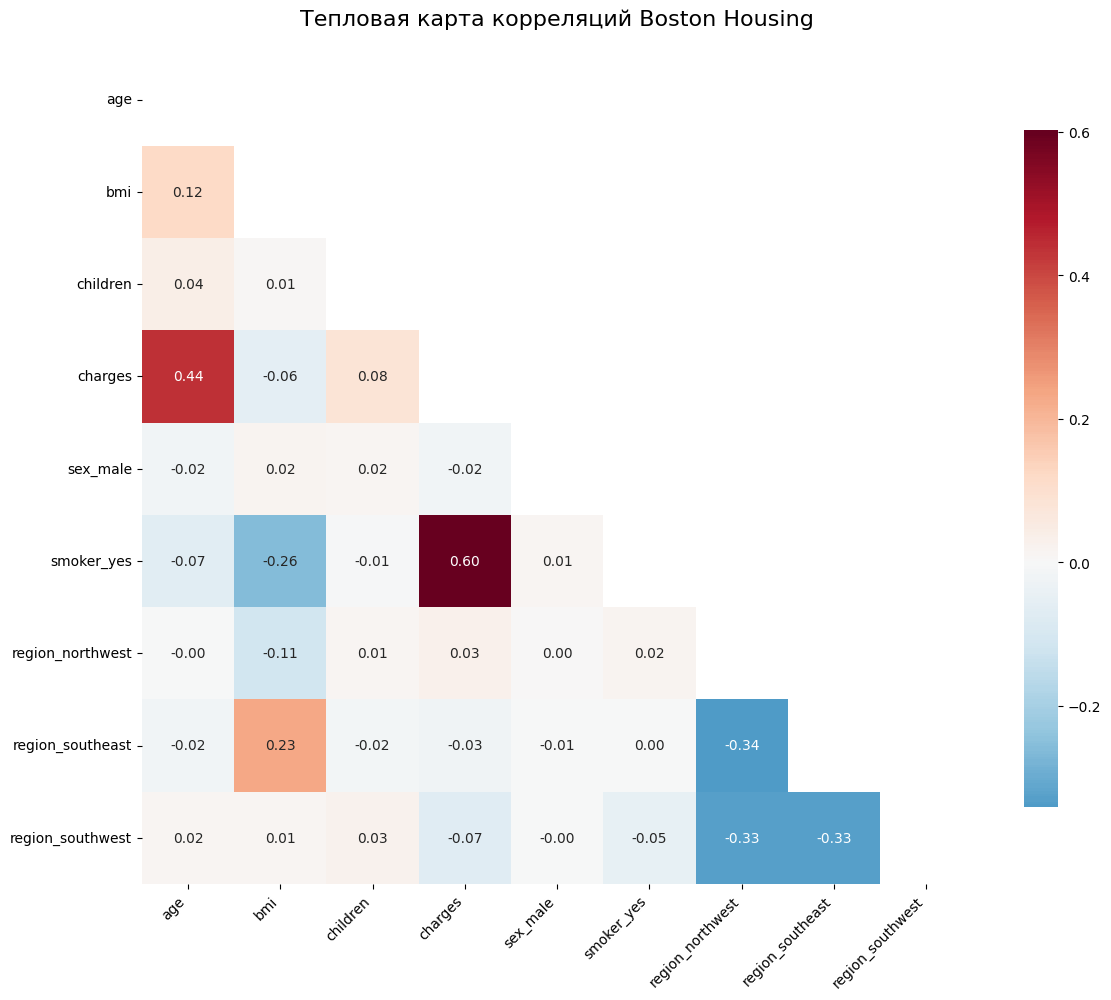

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# 1) Пропуски и выбросы
missing_cnt = df.isna().sum()
missing_pct = (missing_cnt / len(df) * 100).round(2)
missing_table = pd.DataFrame({
    'missing_count': missing_cnt,
    'missing_%': missing_pct
}).sort_values('missing_count', ascending=False)
print('Пропуски (top):')
display(missing_table.head(20))

num_cols = df.select_dtypes(include=[np.number]).columns
q1 = df[num_cols].quantile(0.25)
q3 = df[num_cols].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outlier_mask_any = np.zeros(len(df), dtype=bool)
outlier_counts = {}
for col in num_cols:
    s = df[col]
    mask_col = (s < lower[col]) | (s > upper[col])
    outlier_counts[col] = int(mask_col.sum())
    outlier_mask_any |= mask_col.to_numpy()

outlier_table = pd.DataFrame({'outliers_count': outlier_counts}).sort_values('outliers_count', ascending=False)
print('Выбросы по IQR (top):')
display(outlier_table.head(20))

removed = int(outlier_mask_any.sum())
df_clean = df.loc[~outlier_mask_any].copy()
print(f'Удалено строк-выбросов: {removed}; осталось: {len(df_clean)} из {len(df)}')

# 2) Приведение категориальных и бинарных признаков к числовым (на чистых данных)
# Используем one-hot кодирование для всех категориальных (включая бинарные), drop_first=True
df_model = pd.get_dummies(df_clean, drop_first=True, dtype=int)
print(f'Размер после кодирования (clean): {df_model.shape}')

# 3) Парные корреляции и тепловая карта (на чистых данных)
plt.figure(figsize=(12, 10))
corr_matrix = df_model.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
heatmap = sns.heatmap(corr_matrix,
                      mask=mask,
                      annot=True,
                      cmap='RdBu_r',
                      center=0,
                      square=True,
                      fmt='.2f',
                      cbar_kws={'shrink': 0.8},
                      annot_kws={'size': 10})

plt.title('Тепловая карта корреляций Boston Housing', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Многомерная линейная регрессия

## Аналитически

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

X_df = df_model.drop('charges', axis=1).astype(float)
y = df_model['charges'].astype(float).values.reshape(-1, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df.values)

X_b = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

w_analytical = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

feature_names = ['intercept'] + X_df.columns.tolist()
coef = w_analytical.ravel()
coef_table = pd.DataFrame({'feature': feature_names, 'beta': coef})

print("Коэффициенты:")
for row in coef_table.itertuples(index=False):
    print(f"{row.feature}: {row.beta:.6f}")


Коэффициенты:
intercept: 9942.269682
age: 3405.294470
bmi: 441.848665
children: 503.504753
sex_male: -175.947422
smoker_yes: 4689.998240
region_northwest: -127.216675
region_southeast: -454.550560
region_southwest: -571.303218


## Градиентный спуск

In [15]:
def gradient_descent(X, y, lr=0.01, n_iter=2000, delta_converged=1e-4):
    m, n = X.shape
    w = np.random.randn(n, 1)
    for _ in range(n_iter):
        gradients = 2/m * X.T @ (X @ w - y)
        old_w = w.copy()
        w -= lr * gradients
    
        if np.linalg.norm(w - old_w) < delta_converged:
            print(f"Сходимость достигнута через {_} итераций")
            break
    return w

w_gd = gradient_descent(X_b, y)
print(w_gd)

Сходимость достигнута через 1682 итераций
[[9942.2696816 ]
 [3405.29488236]
 [ 441.84654179]
 [ 503.50446563]
 [-175.94728409]
 [4689.99786229]
 [-127.20809043]
 [-454.54128499]
 [-571.29448894]]


# Добавление регуляризации

## Аналитически

In [29]:
lambda_ = 100
I = np.eye(X_b.shape[1])
I[0,0] = 0
w_ridge_analytical = np.linalg.inv(X_b.T @ X_b + lambda_ * I) @ X_b.T @ y
print(w_ridge_analytical)

[[9942.2696816 ]
 [3131.70421227]
 [ 326.87038065]
 [ 471.6600567 ]
 [-159.74304265]
 [4285.2378361 ]
 [ -66.92436026]
 [-355.63151477]
 [-489.49866587]]


## Численно

In [42]:
def gradient_descent_ridge(X, y, lr=0.01, n_iter=2000, lambda_=0.001, delta_converged=1e-4):
    m, n = X.shape
    w = np.random.randn(n, 1)
    for _ in range(n_iter):
        gradients = 2/m * X.T @ (X @ w - y) + 2 * lambda_ * np.vstack([[0], w[1:]])
        w_new = w - lr * gradients
    
        if np.linalg.norm(w_new - w) < delta_converged:
            print(f"Сходимость достигнута на итерации {_}")
            w = w_new
            break
    
        w = w_new
   
    return w

w_ridge_gd = gradient_descent_ridge(X_b, y)
print(w_ridge_gd)

Сходимость достигнута на итерации 1677
[[9942.2696816 ]
 [3401.76301732]
 [ 440.22301576]
 [ 503.09799039]
 [-175.73097298]
 [4684.694049  ]
 [-126.26385429]
 [-453.05305586]
 [-570.0747885 ]]


# Оценки

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X_b, y, test_size=0.3, random_state=42)

y_pred_const = np.mean(y_train) * np.ones_like(y_test)

y_pred_analytical = X_test @ w_analytical
y_pred_gd = X_test @ w_gd
y_pred_ridge = X_test @ w_ridge_analytical
y_pred_ridge_gd = X_test @ w_ridge_gd

print(f"MSE константной модели: {mean_squared_error(y_test, y_pred_const):.4e}")
print(f"MSE линейной регрессии аналитически: {mean_squared_error(y_test, y_pred_analytical):.4e}")
print(f"MSE линейной регрессии градиентом: {mean_squared_error(y_test, y_pred_gd):.4e}")
print(f"MSE Ridge: {mean_squared_error(y_test, y_pred_ridge):.4e}")
print(f"MSE Ridge_gd: {mean_squared_error(y_test, y_pred_ridge_gd):.4e}")

MSE константной модели: 5.6429e+07
MSE линейной регрессии аналитически: 2.0267e+07
MSE линейной регрессии градиентом: 2.0267e+07
MSE Ridge: 2.0796e+07
MSE Ridge_gd: 2.0271e+07
